In [3]:
import sys
sys.path.append('../')

import os
import ast
import json
import cv2
from glob import glob
from os.path import join as pjoin
from tqdm import tqdm
from PIL import Image

import pandas as pd
import numpy as np
import seaborn as sns

from matplotlib import pyplot as plt

from utils.constants import CLASSES

%matplotlib inline

In [4]:
#sudo apt update
#sudo apt install libgl1-mesa-glx

# RUN apt-get update && apt install libgl1-mesa-glx

# Data

In [5]:
PATH2DIR = '/data'
os.listdir(PATH2DIR)

['tube_masks_640_640',
 'train.csv',
 'train_tfrecords',
 'tube_masks_channel_640_640',
 'tube_masks',
 'sample_submission.csv',
 'train_annotations.csv',
 'test_tfrecords',
 'ranzcr-clip-catheter-line-classification.zip',
 'naive_cv_split.npy',
 'test',
 'tube_masks_channel',
 'train_640_640',
 'test_640_640',
 'train',
 'additional_data']

In [6]:
train = pd.read_csv(pjoin(PATH2DIR, 'train.csv'))
train_annotations = pd.read_csv(pjoin(PATH2DIR, 'train_annotations.csv'))
sample_submission = pd.read_csv(pjoin(PATH2DIR, 'sample_submission.csv'))

In [7]:
cv_split = np.load('/data/naive_cv_split.npy', allow_pickle=True)

cv_split

array([[array([    0,     1,     2, ..., 30079, 30080, 30081]),
        array([    4,     8,    13, ..., 30074, 30076, 30082])],
       [array([    0,     1,     2, ..., 30079, 30081, 30082]),
        array([    5,     7,    21, ..., 30048, 30061, 30080])],
       [array([    0,     1,     4, ..., 30078, 30080, 30082]),
        array([    2,     3,    10, ..., 30066, 30079, 30081])],
       [array([    0,     2,     3, ..., 30080, 30081, 30082]),
        array([    1,    11,    12, ..., 30068, 30073, 30078])],
       [array([    1,     2,     3, ..., 30080, 30081, 30082]),
        array([    0,     6,     9, ..., 30070, 30075, 30077])]],
      dtype=object)

# Observe DF

<AxesSubplot:>

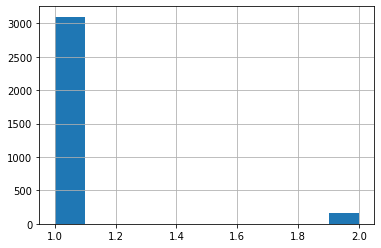

In [6]:
train.groupby('PatientID')['NGT - Abnormal'].nunique().hist()

In [7]:
sample_submission

StudyInstanceUID  ETT - Abnormal  \
0     1.2.826.0.1.3680043.8.498.46923145579096002617...               0   
1     1.2.826.0.1.3680043.8.498.84006870182611080091...               0   
2     1.2.826.0.1.3680043.8.498.12219033294413119947...               0   
3     1.2.826.0.1.3680043.8.498.84994474380235968109...               0   
4     1.2.826.0.1.3680043.8.498.35798987793805669662...               0   
...                                                 ...             ...   
3577  1.2.826.0.1.3680043.8.498.81464483108873296584...               0   
3578  1.2.826.0.1.3680043.8.498.33579133018211530710...               0   
3579  1.2.826.0.1.3680043.8.498.61472811086105902907...               0   
3580  1.2.826.0.1.3680043.8.498.19434375795525494655...               0   
3581  1.2.826.0.1.3680043.8.498.21182456828145534541...               0   

      ETT - Borderline  ETT - Normal  NGT - Abnormal  NGT - Borderline  \
0                    0             0               0                 0   
1                    0             0               0                 0   
2                    0             0               0                 0   
3                    0             0               0                 0   
4                    0             0               0                 0   
...                ...           ...             ...               ...   
3577                 0             0               0                 0   
3578                 0             0               0                 0   
3579                 0             0               0                 0   
3580                 0             0               0                 0   
3581                 0             0               0                 0   

      NGT - Incompletely Imaged  NGT - Normal  CVC - Abnormal  \
0                             0             0               0   
1                             0             0               0   
2                             0             0               0   
3                             0             0               0   
4                             0             0               0   
...                         ...           ...             ...   
3577                          0             0               0   
3578                          0             0               0   
3579                          0             0               0   
3580                          0             0               0   
3581                          0             0               0   

      CVC - Borderline  CVC - Normal  Swan Ganz Catheter Present  
0                    0             0                           0  
1                    0             0                           0  
2                    0             0                           0  
3                    0             0                           0  
4                    0             0                           0  
...                ...           ...                         ...  
3577                 0             0                           0  
3578                 0             0                           0  
3579                 0             0                           0  
3580                 0             0                           0  
3581                 0             0                           0  

[3582 rows x 12 columns]

In [8]:
train

StudyInstanceUID  ETT - Abnormal  \
0      1.2.826.0.1.3680043.8.498.26697628953273228189...               0   
1      1.2.826.0.1.3680043.8.498.46302891597398758759...               0   
2      1.2.826.0.1.3680043.8.498.23819260719748494858...               0   
3      1.2.826.0.1.3680043.8.498.68286643202323212801...               0   
4      1.2.826.0.1.3680043.8.498.10050203009225938259...               0   
...                                                  ...             ...   
30078  1.2.826.0.1.3680043.8.498.74257566841157531124...               0   
30079  1.2.826.0.1.3680043.8.498.46510939987173529969...               0   
30080  1.2.826.0.1.3680043.8.498.43173270582850645437...               0   
30081  1.2.826.0.1.3680043.8.498.95092491950130838685...               0   
30082  1.2.826.0.1.3680043.8.498.99518162226171269731...               0   

       ETT - Borderline  ETT - Normal  NGT - Abnormal  NGT - Borderline  \
0                     0             0               0                 0   
1                     0             1               0                 0   
2                     0             0               0                 0   
3                     0             0               0                 0   
4                     0             0               0                 0   
...                 ...           ...             ...               ...   
30078                 0             1               0                 0   
30079                 0             0               0                 0   
30080                 0             1               0                 0   
30081                 0             0               0                 0   
30082                 0             1               0                 0   

       NGT - Incompletely Imaged  NGT - Normal  CVC - Abnormal  \
0                              0             1               0   
1                              1             0               0   
2                              0             0               0   
3                              0             0               1   
4                              0             0               0   
...                          ...           ...             ...   
30078                          0             0               0   
30079                          0             0               0   
30080                          1             0               1   
30081                          0             0               0   
30082                          0             0               0   

       CVC - Borderline  CVC - Normal  Swan Ganz Catheter Present  PatientID  
0                     0             0                           0  ec89415d1  
1                     0             1                           0  bf4c6da3c  
2                     1             0                           0  3fc1c97e5  
3                     0             0                           0  c31019814  
4                     0             1                           0  207685cd1  
...                 ...           ...                         ...        ...  
30078                 1             1                           0  5b5b9ac30  
30079                 0             1                           0  7192404d8  
30080                 0             1                           0  d4d1b066d  
30081                 1             0                           0  01a6602b8  
30082                 0             1                           0  e692d316c  

[30083 rows x 13 columns]

In [12]:
pd.read_csv('/data/train_without_anot.csv')

StudyInstanceUID  ETT - Abnormal  \
0      1.2.826.0.1.3680043.8.498.26697628953273228189...               0   
1      1.2.826.0.1.3680043.8.498.46302891597398758759...               0   
2      1.2.826.0.1.3680043.8.498.68286643202323212801...               0   
3      1.2.826.0.1.3680043.8.498.10050203009225938259...               0   
4      1.2.826.0.1.3680043.8.498.11707076266253086830...               0   
...                                                  ...             ...   
20983  1.2.826.0.1.3680043.8.498.12112840402677606176...               0   
20984  1.2.826.0.1.3680043.8.498.59704742952729813362...               0   
20985  1.2.826.0.1.3680043.8.498.97304417279653947772...               0   
20986  1.2.826.0.1.3680043.8.498.74257566841157531124...               0   
20987  1.2.826.0.1.3680043.8.498.95092491950130838685...               0   

       ETT - Borderline  ETT - Normal  NGT - Abnormal  NGT - Borderline  \
0                     0             0               0                 0   
1                     0             1               0                 0   
2                     0             0               0                 0   
3                     0             0               0                 0   
4                     0             1               0                 0   
...                 ...           ...             ...               ...   
20983                 0             0               0                 0   
20984                 0             0               0                 0   
20985                 0             0               0                 0   
20986                 0             1               0                 0   
20987                 0             0               0                 0   

       NGT - Incompletely Imaged  NGT - Normal  CVC - Abnormal  \
0                              0             1               0   
1                              1             0               0   
2                              0             0               1   
3                              0             0               0   
4                              0             1               0   
...                          ...           ...             ...   
20983                          0             0               0   
20984                          0             0               1   
20985                          0             0               0   
20986                          0             0               0   
20987                          0             0               0   

       CVC - Borderline  CVC - Normal  Swan Ganz Catheter Present  PatientID  
0                     0             0                           0  ec89415d1  
1                     0             1                           0  bf4c6da3c  
2                     0             0                           0  c31019814  
3                     0             1                           0  207685cd1  
4                     0             1                           0  8260896cf  
...                 ...           ...                         ...        ...  
20983                 1             0                           0  cccbc15ba  
20984                 0             0                           0  172c3c7ed  
20985                 1             0                           0  b304abf90  
20986                 1             1                           0  5b5b9ac30  
20987                 1             0                           0  01a6602b8  

[20988 rows x 13 columns]

In [13]:
len(CLASSES)

11

/opt/conda/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='label', ylabel='count'>

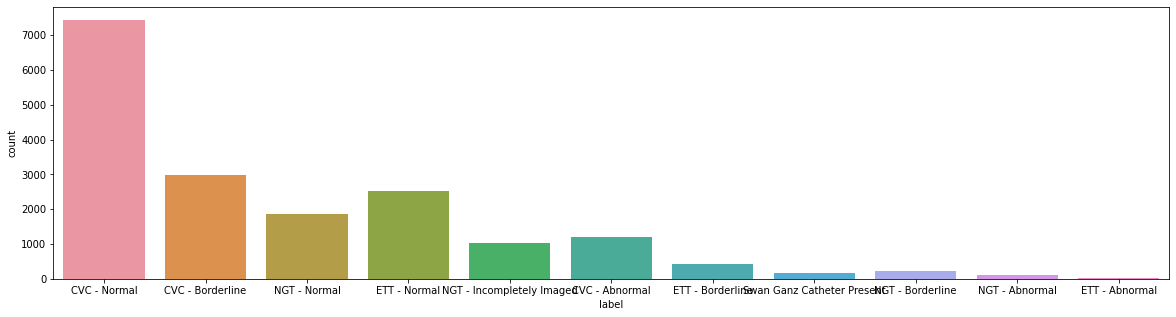

In [12]:
plt.figure(figsize=(20,5))

sns.countplot(train_annotations['label'])

In [186]:
train_annotations.StudyInstanceUID.nunique()

9095

In [198]:
annot_classes = train_annotations.groupby('StudyInstanceUID')['label'].apply(lambda x : np.array(list(set(x))))

In [199]:
train_classes = train[train.StudyInstanceUID.isin(train_annotations.StudyInstanceUID)].set_index('StudyInstanceUID')[CLASSES].apply(lambda x: np.array(CLASSES)[x==1], axis=1)

In [200]:
annot_classes.sort_index() == train_classes.sort_index()

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [201]:
annot_classes

StudyInstanceUID
1.2.826.0.1.3680043.8.498.10000428974990117276582711948006105617                                      [CVC - Normal]
1.2.826.0.1.3680043.8.498.10002446304107330308555550280339793610                                      [CVC - Normal]
1.2.826.0.1.3680043.8.498.10006237848798781176388878065969229683        [CVC - Normal, NGT - Abnormal, ETT - Normal]
1.2.826.0.1.3680043.8.498.10006912914592266370941646234626874697    [CVC - Borderline, CVC - Abnormal, NGT - Normal]
1.2.826.0.1.3680043.8.498.10008193698745944671737283077530844393                                      [CVC - Normal]
                                                                                          ...                       
1.2.826.0.1.3680043.8.498.99971231542589897710744415581839623025          [CVC - Normal, ETT - Normal, NGT - Normal]
1.2.826.0.1.3680043.8.498.99971919985113251695401367974124184826                                      [CVC - Normal]
1.2.826.0.1.3680043.8.498.999747574961768217200

In [215]:
len_mask = [sorted(v1) != sorted(v2) for v1, v2 in zip(annot_classes.sort_index(), train_classes.sort_index())]

In [216]:
print(sum(len_mask))

24


In [217]:
train_classes.sort_index()[len_mask]

StudyInstanceUID
1.2.826.0.1.3680043.8.498.10032779745111029961725732567447430519    [CVC - Borderline, CVC - Normal, Swan Ganz Cat...
1.2.826.0.1.3680043.8.498.10610486271423711625301125615257383025           [CVC - Normal, Swan Ganz Catheter Present]
1.2.826.0.1.3680043.8.498.11147946794753872821366354110254647425    [ETT - Normal, CVC - Normal, Swan Ganz Cathete...
1.2.826.0.1.3680043.8.498.11191767432917952290990432455633048731    [NGT - Normal, CVC - Normal, Swan Ganz Cathete...
1.2.826.0.1.3680043.8.498.11409973134529266656583367150961222840           [CVC - Normal, Swan Ganz Catheter Present]
1.2.826.0.1.3680043.8.498.12675677922449124446623592783156035972    [CVC - Borderline, CVC - Normal, Swan Ganz Cat...
1.2.826.0.1.3680043.8.498.12955628616474310875677591692106308039    [CVC - Abnormal, CVC - Normal, Swan Ganz Cathe...
1.2.826.0.1.3680043.8.498.12959346041796434407690639001695004514           [CVC - Normal, Swan Ganz Catheter Present]
1.2.826.0.1.3680043.8.498.1321227325516

In [218]:
annot_classes.sort_index()[len_mask]

StudyInstanceUID
1.2.826.0.1.3680043.8.498.10032779745111029961725732567447430519       [CVC - Borderline, Swan Ganz Catheter Present]
1.2.826.0.1.3680043.8.498.10610486271423711625301125615257383025                         [Swan Ganz Catheter Present]
1.2.826.0.1.3680043.8.498.11147946794753872821366354110254647425           [Swan Ganz Catheter Present, ETT - Normal]
1.2.826.0.1.3680043.8.498.11191767432917952290990432455633048731           [Swan Ganz Catheter Present, NGT - Normal]
1.2.826.0.1.3680043.8.498.11409973134529266656583367150961222840                         [Swan Ganz Catheter Present]
1.2.826.0.1.3680043.8.498.12675677922449124446623592783156035972       [CVC - Borderline, Swan Ganz Catheter Present]
1.2.826.0.1.3680043.8.498.12955628616474310875677591692106308039         [CVC - Abnormal, Swan Ganz Catheter Present]
1.2.826.0.1.3680043.8.498.12959346041796434407690639001695004514                         [Swan Ganz Catheter Present]
1.2.826.0.1.3680043.8.498.1321227325516

In [9]:
classes = train.columns.tolist()[1:-1]

classes

['ETT - Abnormal',
 'ETT - Borderline',
 'ETT - Normal',
 'NGT - Abnormal',
 'NGT - Borderline',
 'NGT - Incompletely Imaged',
 'NGT - Normal',
 'CVC - Abnormal',
 'CVC - Borderline',
 'CVC - Normal',
 'Swan Ganz Catheter Present']

/opt/conda/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


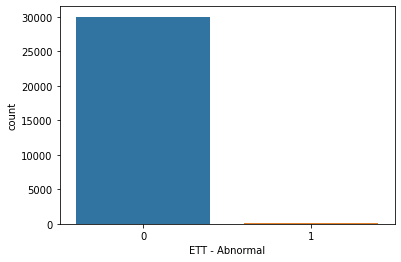

/opt/conda/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


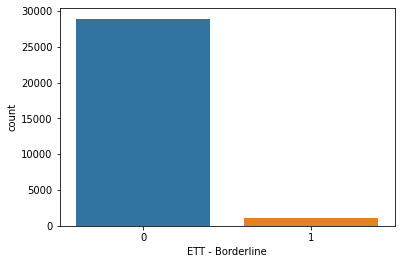

/opt/conda/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


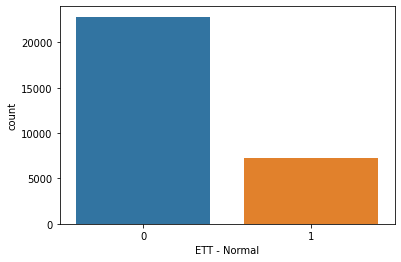

/opt/conda/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


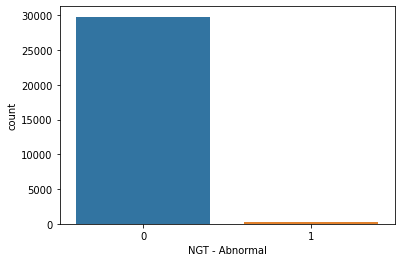

/opt/conda/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


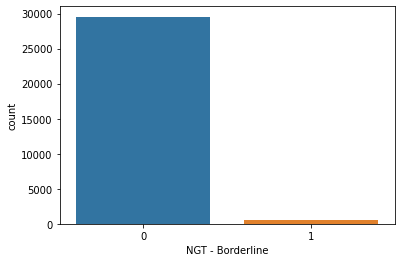

/opt/conda/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


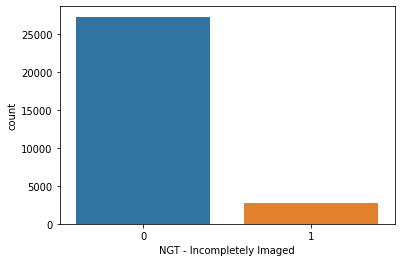

/opt/conda/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


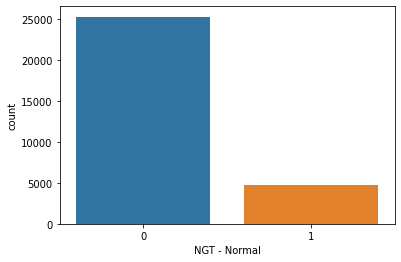

/opt/conda/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


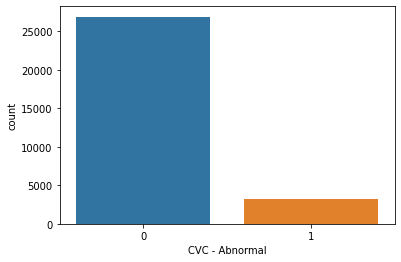

/opt/conda/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


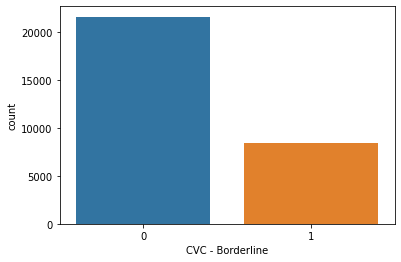

/opt/conda/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


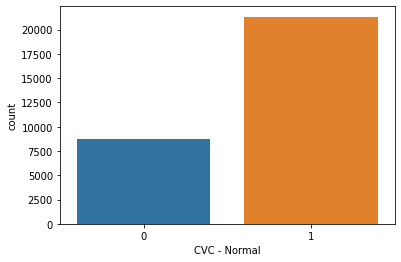

/opt/conda/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


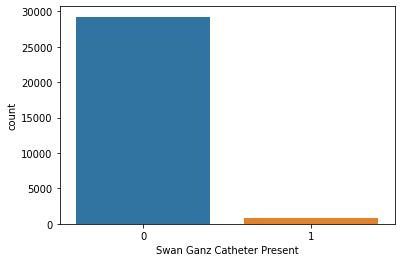

In [10]:
for cl in classes:
    sns.countplot(train[cl])
    plt.show()

In [11]:
sub_train = train.iloc[cv_split[0][1]]

/opt/conda/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


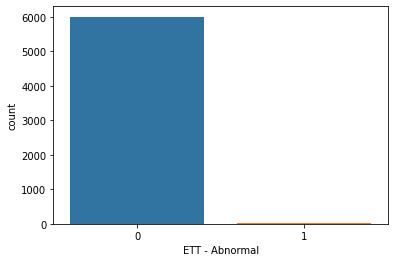

/opt/conda/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


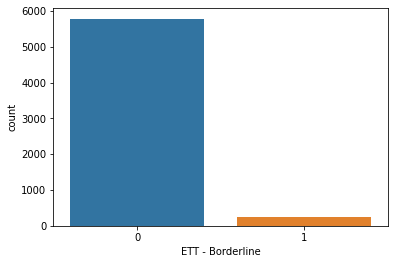

/opt/conda/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


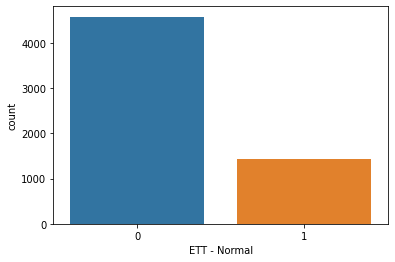

/opt/conda/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


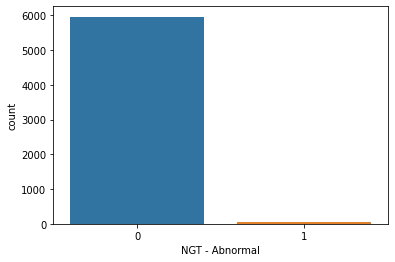

/opt/conda/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


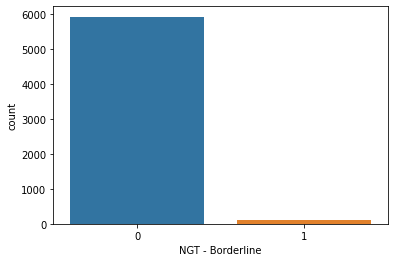

/opt/conda/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


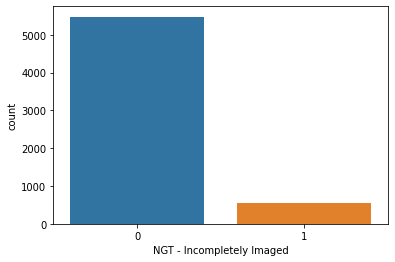

/opt/conda/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


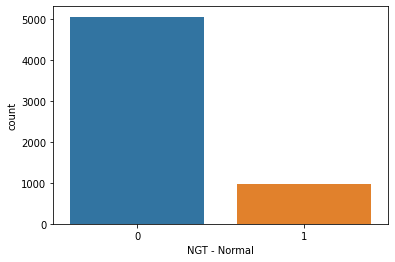

/opt/conda/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


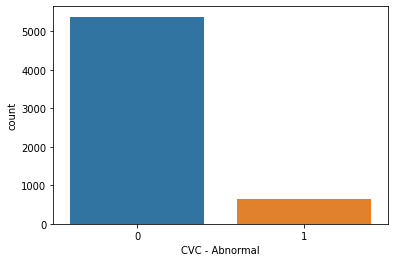

/opt/conda/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


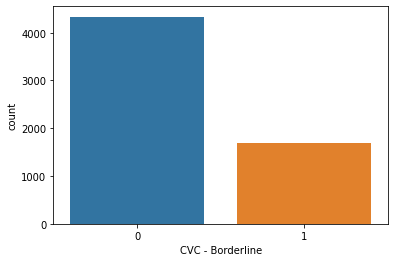

/opt/conda/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


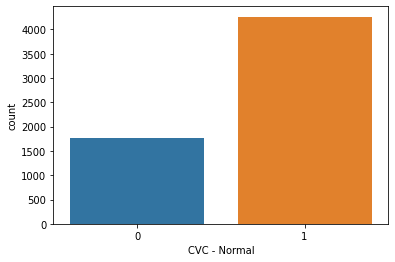

/opt/conda/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


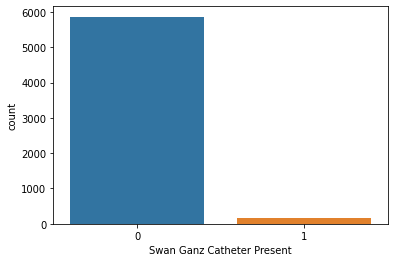

In [12]:
for cl in classes:
    sns.countplot(sub_train[cl])
    plt.show()

# Images

In [21]:
all_train_files = glob(pjoin(PATH2DIR, 'train/*.jpg'))
print(f"{len(all_train_files)} train files")
all_test_files = glob(pjoin(PATH2DIR, 'test/*.jpg'))
print(f"{len(all_test_files)} test files")

30083 train files
3582 test files


In [22]:
def read_image_shapes(filename: str):
    return cv2.imread(filename).shape

In [ ]:
train_image_shape = [read_image_shapes(el) for el in tqdm(all_train_files)]
test_image_shape = [read_image_shapes(el) for el in tqdm(all_test_files)]

In [ ]:
train_image_shape = np.stack(train_image_shape)
test_image_shape = np.stack(test_image_shape)

print(f"First axis: {np.unique(train_image_shape[:,0])}. Second axis: {np.unique(train_image_shape[:,1])}. Third axis: {np.unique(train_image_shape[:,2])}.")
print(f"First axis: {np.unique(test_image_shape[:,0])}. Second axis: {np.unique(test_image_shape[:,1])}. Third axis: {np.unique(test_image_shape[:,2])}.")

In [ ]:
plt.title('Train Axis 0 size dist')
plt.hist(train_image_shape[:,0])
plt.show()

plt.title('Train Axis 1 size dist')
plt.hist(train_image_shape[:,1])
plt.show()

plt.title('Test Axis 0 size dist')
plt.hist(test_image_shape[:,0])
plt.show()

plt.title('Test Axis 1 size dist')
plt.hist(test_image_shape[:,1])
plt.show()

In [343]:
glob('/data/tube_masks/*.jpeg')

['/data/tube_masks/1.2.826.0.1.3680043.8.498.83154112055386952341967546032205226007.jpeg',
 '/data/tube_masks/1.2.826.0.1.3680043.8.498.35266556746740313222804683294939967585.jpeg',
 '/data/tube_masks/1.2.826.0.1.3680043.8.498.11461166821262935320163336144988046037.jpeg',
 '/data/tube_masks/1.2.826.0.1.3680043.8.498.13097515569994901583962539440164549248.jpeg',
 '/data/tube_masks/1.2.826.0.1.3680043.8.498.58299555810332470891548102820601520736.jpeg',
 '/data/tube_masks/1.2.826.0.1.3680043.8.498.13308626137723201082136868427816406950.jpeg',
 '/data/tube_masks/1.2.826.0.1.3680043.8.498.88867293276133309723185251459791683842.jpeg',
 '/data/tube_masks/1.2.826.0.1.3680043.8.498.65744560518076297687954273751959969284.jpeg',
 '/data/tube_masks/1.2.826.0.1.3680043.8.498.10214733722328213639799519292896669691.jpeg',
 '/data/tube_masks/1.2.826.0.1.3680043.8.498.57157757026101830496648587022138856131.jpeg',
 '/data/tube_masks/1.2.826.0.1.3680043.8.498.81337140683995128509675651480317951677.jpeg',

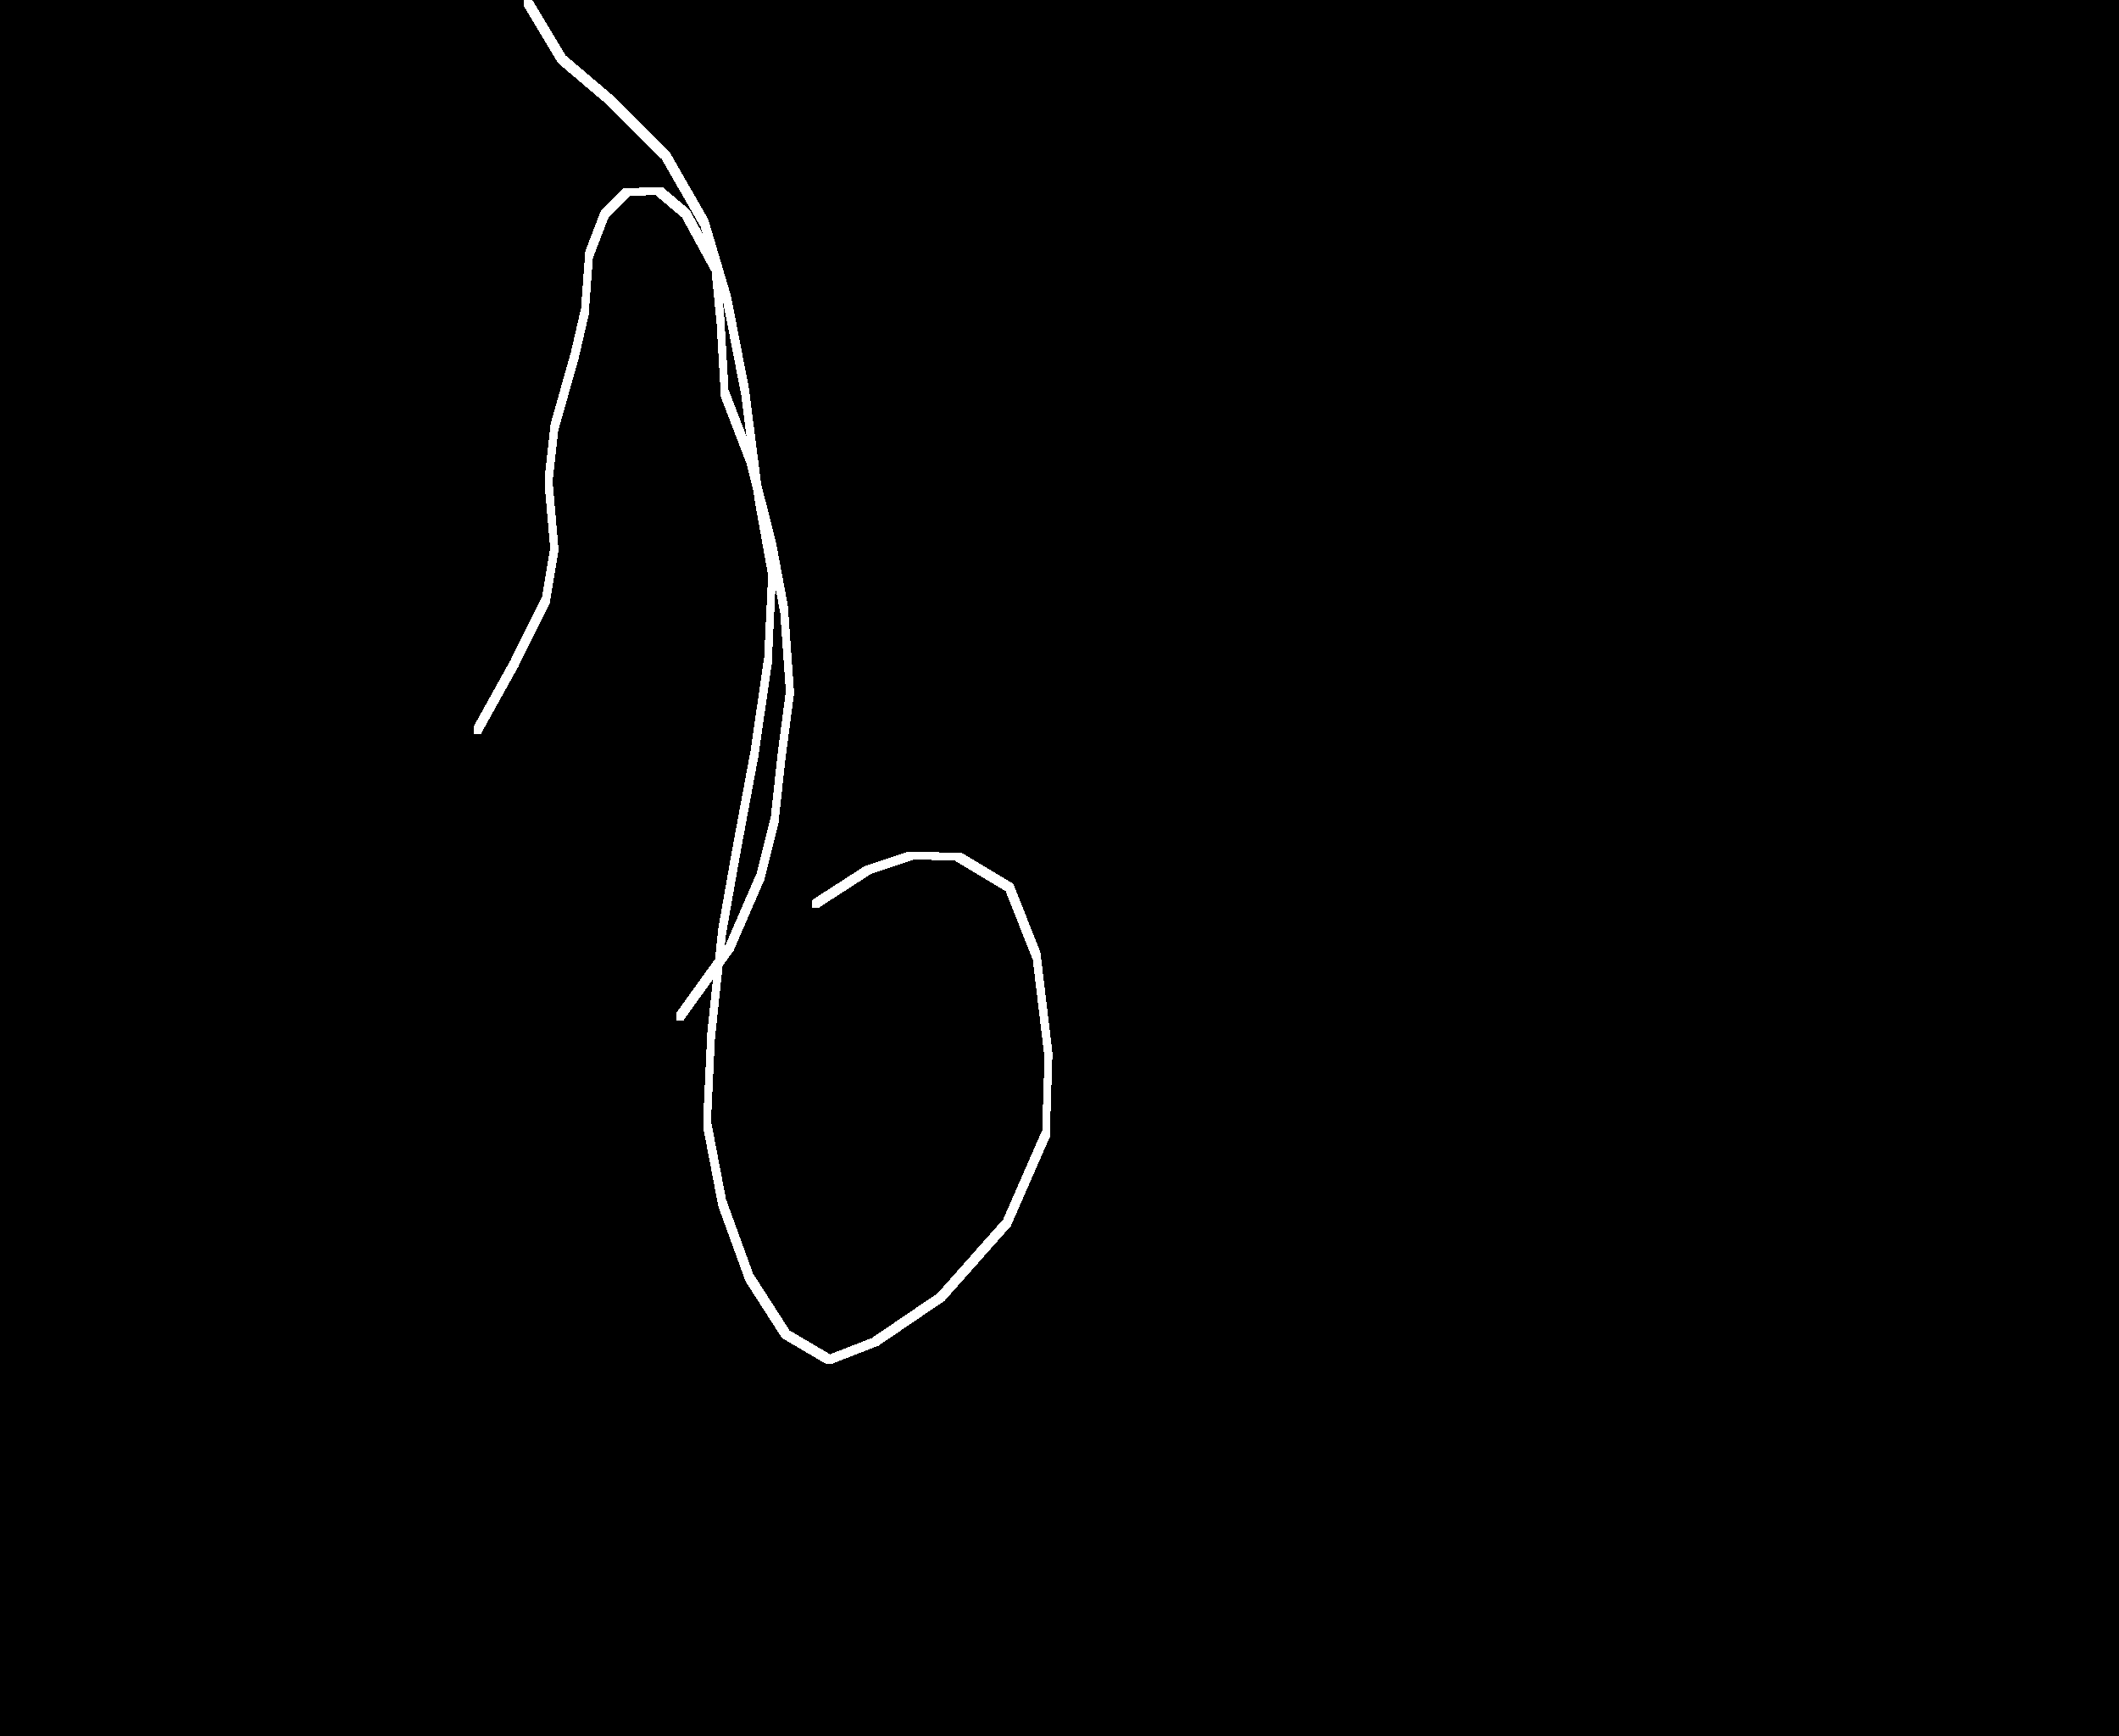

In [344]:
temp_im = Image.open('/data/tube_masks/1.2.826.0.1.3680043.8.498.10032779745111029961725732567447430519.jpeg')
temp_im

In [330]:
train[train.StudyInstanceUID == '1.2.826.0.1.3680043.8.498.10032779745111029961725732567447430519']

StudyInstanceUID  ETT - Abnormal  \
4650  1.2.826.0.1.3680043.8.498.10032779745111029961...               0   

      ETT - Borderline  ETT - Normal  NGT - Abnormal  NGT - Borderline  \
4650                 0             0               0                 0   

      NGT - Incompletely Imaged  NGT - Normal  CVC - Abnormal  \
4650                          0             0               0   

      CVC - Borderline  CVC - Normal  Swan Ganz Catheter Present  PatientID  \
4650                 1             1                           1  9ded8f906   

             merged_classes  merged_id  
4650  0.0.0.0.0.0.0.0.1.1.1          5

In [243]:
Image.fromarray(temp_im).resize((512,512), Image.ANTIALIAS).save('temp1.jpeg', 'JPEG', quality=100)

In [39]:
from os.path import splitext

DIALIATION_KERNEL = np.ones((9,9),np.uint8)

def show_image_by_name(
    filename: str,
    is_train: bool,
    do_show: bool = True
):
    temp_im = cv2.imread(pjoin(
        PATH2DIR, 
        'train_640_640' if is_train else 'test',
        filename
    ))
    plt.figure(figsize=(10,10))
    temp_im = cv2.cvtColor(temp_im, cv2.COLOR_BGR2RGB)
    plt.imshow(temp_im)
    if do_show:
        plt.show()
    return temp_im
        
def show_mask_by_name(
    filename: str,
    image: np.ndarray = None,
    is_tube: bool = False,
    do_show: bool = True
):
    plt.figure(figsize=(10,10))
    if is_tube: 
        #mask = np.array(Image.open(pjoin(PATH2DIR, 'tube_masks_512_512', filename)))
        mask = np.load(pjoin('/data/tube_masks_channel_640_640', filename)) 
    else:
        mask = np.array(Image.open(pjoin('/data/additional_data/train_lung_masks/train_lung_masks_640_640', filename)))
    if image is None:
        if len(mask.shape) == 2:
            plt.imshow(mask)
        else:
            for i, cls_n in enumerate(CLASSES):
                plt.title(cls_n)
                plt.imshow(mask[:,:,i])
                if do_show:
                    plt.show()
    else:
        if len(mask.shape) == 2:
            tt_image = image[:,:,0].copy()
            tt_image[mask == 0] = tt_image[mask == 0] * 0.5
            plt.imshow(tt_image)
        else:
            for i, cls_n in enumerate(CLASSES):
                plt.title(cls_n)
                tt_image = image[:,:,0].copy()
                tt_image[mask[:,:,i] == 0] = tt_image[mask[:,:,i] == 0] * 0.5
                plt.imshow(tt_image) 
                if do_show:
                    plt.show()
    if do_show:
        plt.show()
        
def create_tube_mask(filename):
    sub_df = train_annotations[train_annotations.StudyInstanceUID == filename]
    full_name = pjoin('/data/train', filename + '.jpg')
    shape = read_image_shapes(full_name)
    mask = np.zeros((len(CLASSES),*shape[:-1]))
    for i in range(sub_df.shape[0]):
        cls_id = CLASSES.index(sub_df.iloc[i].label)
        one_mask = create_mask(sub_df.iloc[i].data, full_name)
        mask[cls_id] = one_mask
    mask = (mask.sum(0) > 0).astype(np.uint8)
    mask = mask * 255
    return cv2.dilate(mask,DIALIATION_KERNEL,iterations = 1)
    
def show_raw(idx: int):
    
    raw = train.iloc[idx]
    
    print(raw)
    print(raw.StudyInstanceUID)
    
    t_image = show_image_by_name(raw.StudyInstanceUID + '.jpeg', is_train=True)
    show_mask_by_name(raw.StudyInstanceUID + '.jpeg', t_image)
    
    if raw.StudyInstanceUID in train_annotations.StudyInstanceUID.tolist():
        #tube_mask = create_tube_mask(raw.StudyInstanceUID)
        show_mask_by_name(raw.StudyInstanceUID + '.npy', t_image, is_tube=True)
        annotaion_raws = train_annotations[train_annotations.StudyInstanceUID == raw.StudyInstanceUID]
        for j in range(annotaion_raws.shape[0]):
            annot_raw = annotaion_raws.iloc[j]
            print(annot_raw.label)
            points = np.array(ast.literal_eval(annot_raw.data))
            show_image_by_name(raw.StudyInstanceUID + '.jpeg', is_train=True, do_show=False)
            plt.scatter(points[:,0], points[:,1])
            plt.show()

In [40]:
train[train.StudyInstanceUID.isin(train_annotations.StudyInstanceUID)].tail(30)

StudyInstanceUID  ETT - Abnormal  \
29980  1.2.826.0.1.3680043.8.498.85632903081031584252...               0   
29986  1.2.826.0.1.3680043.8.498.10289780812614346085...               0   
29989  1.2.826.0.1.3680043.8.498.65208811596203943866...               0   
29994  1.2.826.0.1.3680043.8.498.57431394029465906897...               0   
29997  1.2.826.0.1.3680043.8.498.83256203058318721651...               0   
29999  1.2.826.0.1.3680043.8.498.73054190252607056426...               0   
30002  1.2.826.0.1.3680043.8.498.56988390009342737007...               0   
30004  1.2.826.0.1.3680043.8.498.44987966894883038046...               0   
30005  1.2.826.0.1.3680043.8.498.27167552253204417138...               0   
30007  1.2.826.0.1.3680043.8.498.12265363134238934638...               0   
30009  1.2.826.0.1.3680043.8.498.45248903188033198256...               0   
30010  1.2.826.0.1.3680043.8.498.11826481935912541615...               0   
30021  1.2.826.0.1.3680043.8.498.40478688820218019919...               0   
30022  1.2.826.0.1.3680043.8.498.85012902893400238982...               0   
30024  1.2.826.0.1.3680043.8.498.13115270973179925140...               0   
30026  1.2.826.0.1.3680043.8.498.34908450415232161801...               0   
30027  1.2.826.0.1.3680043.8.498.12530901561532081878...               0   
30038  1.2.826.0.1.3680043.8.498.61479011984590895285...               0   
30043  1.2.826.0.1.3680043.8.498.11008090864695224249...               0   
30045  1.2.826.0.1.3680043.8.498.77914080043740006468...               0   
30053  1.2.826.0.1.3680043.8.498.44243345248988583961...               0   
30054  1.2.826.0.1.3680043.8.498.14804754843326101708...               0   
30056  1.2.826.0.1.3680043.8.498.88232185276535677583...               0   
30058  1.2.826.0.1.3680043.8.498.28991063692775679367...               0   
30060  1.2.826.0.1.3680043.8.498.75445875862496758679...               0   
30063  1.2.826.0.1.3680043.8.498.10971556774256804583...               0   
30071  1.2.826.0.1.3680043.8.498.53525361705976355115...               0   
30079  1.2.826.0.1.3680043.8.498.46510939987173529969...               0   
30080  1.2.826.0.1.3680043.8.498.43173270582850645437...               0   
30082  1.2.826.0.1.3680043.8.498.99518162226171269731...               0   

       ETT - Borderline  ETT - Normal  NGT - Abnormal  NGT - Borderline  \
29980                 0             0               0                 0   
29986                 1             0               0                 0   
29989                 0             0               0                 0   
29994                 0             1               0                 0   
29997                 0             1               0                 0   
29999                 0             1               0                 0   
30002                 1             0               0                 0   
30004                 0             0               0                 0   
30005                 0             0               0                 0   
30007                 0             1               0                 0   
30009                 0             0               0                 0   
30010                 0             1               0                 0   
30021                 0             1               0                 0   
30022                 0             1               0                 0   
30024                 1             0               0                 0   
30026                 0             0               0                 0   
30027                 0             0               0                 0   
30038                 0             0               0                 0   
30043                 0             0               0                 0   
30045                 0             0               0                 1   
30053                 0             1               0                 0   
30054                 0          

StudyInstanceUID              1.2.826.0.1.3680043.8.498.43173270582850645437...
ETT - Abnormal                                                                0
ETT - Borderline                                                              0
ETT - Normal                                                                  1
NGT - Abnormal                                                                0
NGT - Borderline                                                              0
NGT - Incompletely Imaged                                                     1
NGT - Normal                                                                  0
CVC - Abnormal                                                                1
CVC - Borderline                                                              0
CVC - Normal                                                                  1
Swan Ganz Catheter Present                                                    0
PatientID                               

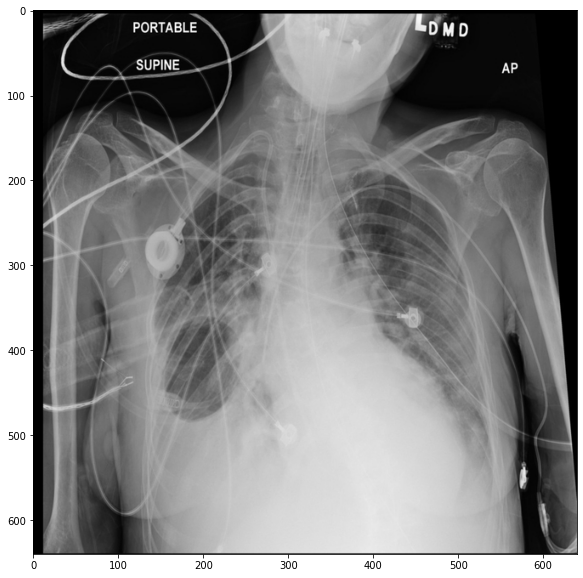

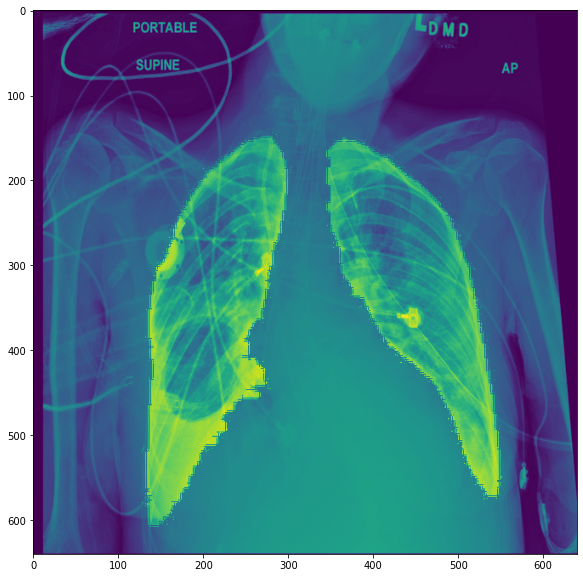

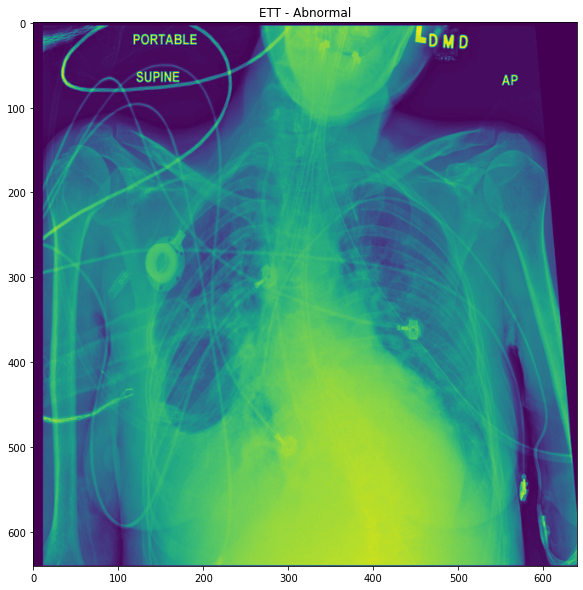

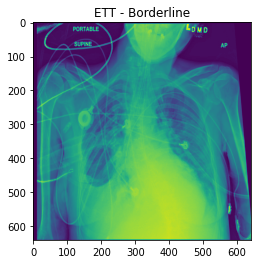

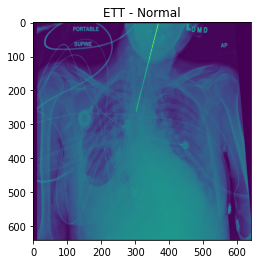

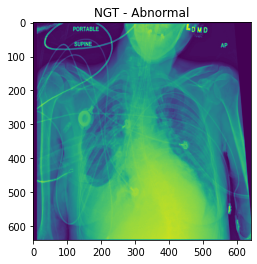

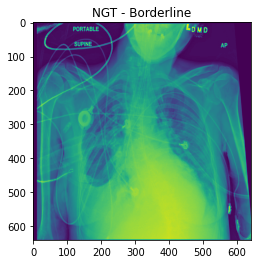

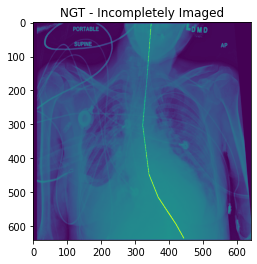

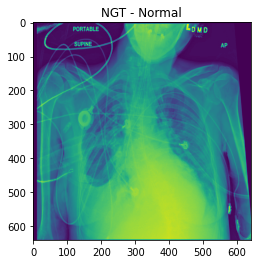

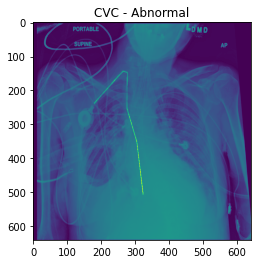

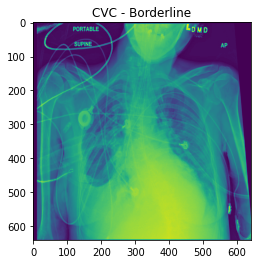

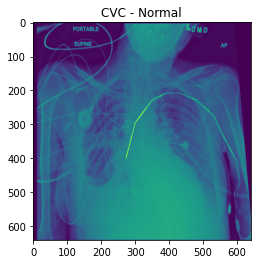

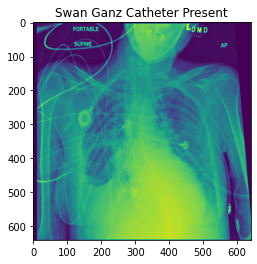

ETT - Normal


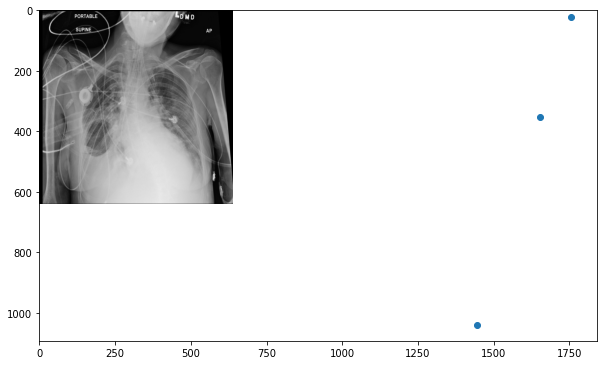

NGT - Incompletely Imaged


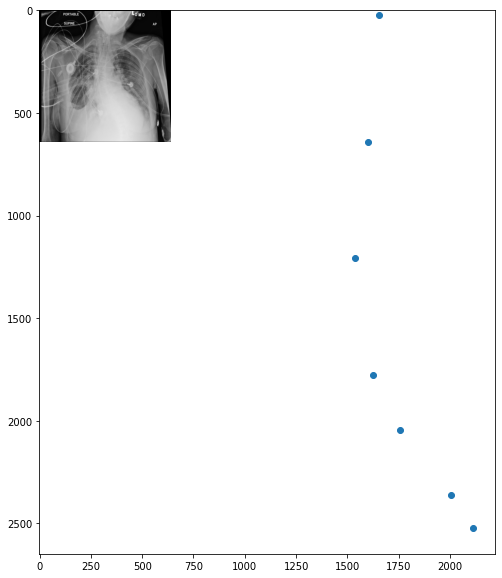

CVC - Normal


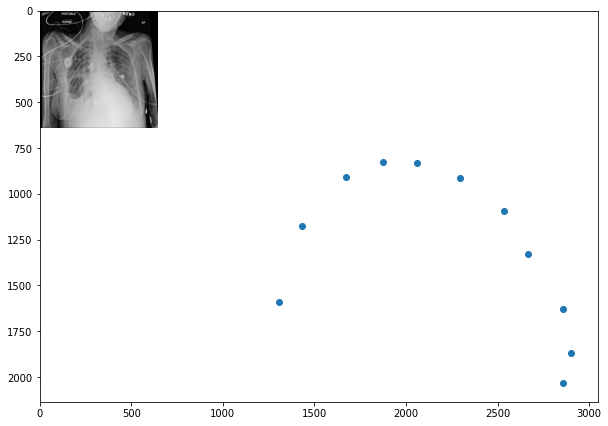

CVC - Abnormal


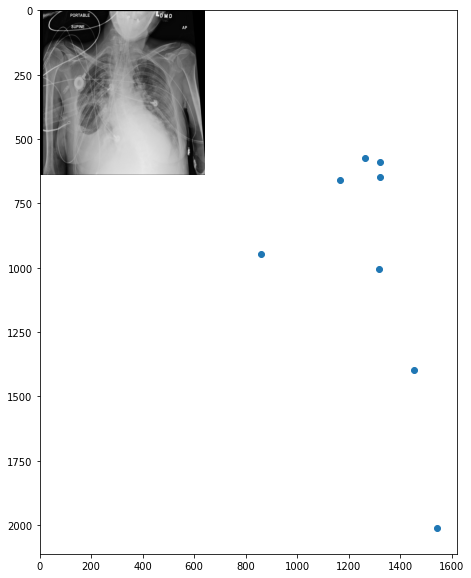

In [41]:
show_raw(30080)